<a href="https://colab.research.google.com/github/Diana-ops/diananeri/blob/master/Classifica%C3%A7%C3%A3o_de_Imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Gatos e Cachorros com Redes Neurais Convolucionais (CNN)

Diferenciar gatos e cachorros é algo que fazemos desde criança, mas não é uma habilidade inata (até porque, uma das poucas coisas que sabemos fazer ao nascer é chorar e comer). O que acontece, é que enquanto estamos crescendo vemos gatos e cachorros na TV, escola, rua e até mesmo em casa, então quando começamos a falar até já sabemos falar _o que é cachorro e o que é gato_. 

![](https://www.doctum.edu.br/wp-content/uploads/2017/11/quiz_gato_ou_cao.jpg)

_Fonte da Imagem: https://www.doctum.edu.br/wp-content/uploads/2017/11/quiz_gato_ou_cao.jpg_

Esse processo de vê-los e associa-los como um ou outro pode ser chamado de **aprendizado**, e quando já sebemos qual é qual chamamos de **validação**.

Na verdade, até hoje fazemos isso com tudo na vida e não só com animais de estimação. No transito por exemplo, é comum termos que diferenciar carros de caminhão, bicicletas, pedestres e outros, pois dependendo que está a nossa frente tomaremos **dicisões diferentes**. 

Para construir **carros autonomos**, é necessário desenvolver um sistema que também tenha essa capacidade. Portanto, começaremos a fazer isso neste artigo, isto é, realizando uma pequena aplicação capaz de aprender a diferenciar esses elementos. 


Para realizar essa aplicação, utilizaremos: 
1. Python 3.6.9
2. Google Drive
3. Biblioteca Tensorflow
4. _Dataset_ das imagens para treinamento: https://www.kaggle.com/c/dogs-vs-cats

## 1. Baixando o _Dataset_ do Kaggle no Google Drive 

O **Kaggle** é uma plataforma que possui _datasets_ sobre diversos temas como governo, esportes, comida, sociedade e outros, sendo utilizados para trabalhar com ciencia de dados e aprendizado de maquina. Também é possível participar de competições para solucinar problemas que envolve essas áreas. É nesta plataforma que encontraremos as imagens dos gatos e cachorros. 

O **Google Drive** é um recurso do google para amazenamento de dados na nuvem, sendo possível baixar o _dataset_ nele e utiliza-lo aqui no **Google Colab** para realizar o processamento. 




Primeiro, vamos fazer a conexão com o google drive. Ao executar a célula seguinte, clique no link, entre em uma conta no drive, copie o código que será gerado e cole na caixa aqui abaixo. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Para baixar uma base de dados, é necessário ter uma conta no site (https://www.kaggle.com/). 

Ao criar a conta, vá em: **"My Account" >> "Create New API Token"**. Em seguida, um arquivo "kaggle.json" será automaticamente carregado em sua máquina e ele deverá ser extraido após a execução da célula abaixo:

In [0]:
from google.colab import files
files.upload()  #Selecione o arquivo "kaggle.json"

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dianargn","key":"d29b53fb0a50d2c7252949a9f14bd9a5"}'}

Execute a célula abaixo: 

In [0]:
!pip install -q kaggle 
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  

kaggle.json


Para baixar qualquer dataset do Kaggle, entre na janela correspondente (no nosso caso seria: https://www.kaggle.com/c/dogs-vs-cats), depois em **data** e copie o **link ao lado de API**.

Para baixar especificamente o _dataset_ com as imagens dos gatos e cachorros execute a célula abaixo: 

In [0]:
!kaggle competitions download -c dogs-vs-cats -p /content/gdrive/My\ Drive/kaggle/dogscats 

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
sh: 0: getcwd() failed: No such file or directory
 98% 530M/543M [00:04<00:00, 117MB/s]
100% 543M/543M [00:04<00:00, 119MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 11.4MB/s]
 98% 267M/271M [00:02<00:00, 111MB/s]
100% 271M/271M [00:02<00:00, 108MB/s]


Execute a célula abaixo para criar os diretórios que armazenarão as imagens 

In [0]:
import os
os.chdir('/content/gdrive/My Drive/kaggle/dogscats')  #change dir
if not os.path.exists("treino"):
  os.mkdir("treino")  #Cria um diretório chamado treino

if not os.path.exists("teste"):
  os.mkdir("treino")  #Cria um diretório chamado teste

if not os.path.exists("valida"):
  os.mkdir("valida")  #Cria um diretório chamado valida

Execute a célula abaixo para desempacotar o _dataset_ e armazenar nos diretórios 

In [0]:
!unzip -q train.zip -d treino/  #desempacota para o diretório "treino"
!unzip -q test1.zip -d teste/  #desempacota para o diretório "teste"

### 2. Preparando o _Dataset_ para a partir das imagens 

In [2]:
# Bibliotecas para a construção e uso da RNA 
import tensorflow.compat.v1 as tf 
import keras 
import keras.backend as K
from keras.layers import Dense, Conv2D, Input, MaxPooling2D, Flatten, Dropout
from keras.models import Model
from keras.datasets import fashion_mnist
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image

# Outras Bibliotecas 
from google.colab.patches import cv2_imshow
import numpy as np 
import random, os
import matplotlib.pyplot as plt 
from matplotlib import cm
import cv2 

%matplotlib inline

Using TensorFlow backend.


Ao executar a célula abaixo, as imagens serão armazenadas na lista "treino" e a partir do nome dessa imagem será inserido o valor 0 na lista "y_treino" caso ela seja corresponde a um gato, ou 1, caso seja correspondente a um cachorro. 

É posível controlar a quantidade de dados que será utilizado no treinamento da rede a partir da variável "tan_dat".

In [12]:
treino, y_treino = [], []
n = 20

#Acesso ao diretório 
dir_treino = os.listdir('/content/gdrive/My Drive/kaggle/dogscats/treino/train')

#Construindo uma lista com os dados de entrada e saida da rede 

"""
O terceiro parametro irá dividr o nosso dataset em n vezes,
mas vale lembrar que quanto mais imagens forem fornecidas melhor será o treinamento da rede,
no entanto, o tempo de processamento será maior
"""
for i in range(0, len(dir_treino), n):
  if "cat." in dir_treino[i]:
    treino.append(dir_treino[i])
    y_treino.append(0) #Saída 0 - Gatos 

  if "dog." in dir_treino[i]:
    treino.append(dir_treino[i]) 
    y_treino.append(1) #Saída 1 - Cachorros 

852


Para as imagens de teste, o _dataset_ fornecido pelo Kaggle as renomeou apenas numricamente, isto é, sem indicar se era um cachorro ou gato. Isso complica um pouco as coisas pois saber a resposta correta dos dados de teste nos ajuda a medir o desempenho da rede. 

No material desenvolvido por Cleuton Sampaio [1], foi sugerido que o usuário renomeasse essas imagens antes de utiliza-las. O que eu fiz foi criar **manualmente** (isto é, usar código), a criação de 2 diretórios: "dog" e "cat". Depois, separei 30 imagens de gato e cachorro para elas e em seguida executei a célula a seguir para renomear essas imagens. 

### Execute esta célula para renomear as imagens dos diretórios "Dog" e "Cat" que foram criadas

In [0]:
dir_teste = os.listdir('/content/gdrive/My Drive/kaggle/dogscats/teste/test1/dog')
ca = '/content/gdrive/My Drive/kaggle/dogscats/teste/test1/'
for i in range(0, len(dir_teste)):
   if not "dog." in dir_teste[i]:
     os.rename(ca+"dog/"+dir_teste[i], ca+"dog/dog."+dir_teste[i])

dir_teste = os.listdir('/content/gdrive/My Drive/kaggle/dogscats/teste/test1/cat')
for i in range(0, len(dir_teste)):
   if not "cat." in dir_teste[i]:
     os.rename(ca+"cat/"+dir_teste[i], ca+"cat/cat."+dir_teste[i])

Para deixar as imagens de teste com o mesmo "padrão" das de treinamento, **mova as imagens para o diretório '/content/gdrive/My Drive/kaggle/dogscats/teste** e execute a célula abaixo para realizar o mesmo para o treinamento

In [0]:
dir_teste = os.listdir('/content/gdrive/My Drive/kaggle/dogscats/teste')

y_teste, teste = [], [] #Armazena a resposta correta das imagens teste

for i in range(0, len(dir_teste)):
   if "dog." in dir_teste[i] and dir_teste[i] not in teste:
     teste.append(dir_teste[i])
     y_teste.append(1)

for i in range(0, len(dir_teste)):
   if "cat." in dir_teste[i] and dir_teste[i] not in teste:
     teste.append(dir_teste[i])
     y_teste.append(0)

In [0]:
batch_sz = 64 # Batch size
nb_class = 2  # Número de classes
nb_epochs = 10 # Número de epochs de treinamento
img_h, img_w = 64, 64 # Altura e largura das imagens
caminho = '/content/gdrive/My Drive/kaggle/dogscats'

In [0]:
def ler_imagem(file):

    #Leitura da imagem 
    img = cv2.imread(file)
    
    #Converte para escala cinza 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #Muda o tamanho da imagem 
    imres = cv2.resize(gray, (img_h, img_w), interpolation=cv2.INTER_CUBIC)

    #Obtem os pixels da imagem e os insere em uma matriz 
    imres = image.img_to_array(imres.T)
    imres = np.expand_dims(imres, axis = 0)    
    return imres

In [0]:
def gerar_dataset(path, filenames):

    #Cria uma matriz do tamanho da quantidade de imagens encontrado ora no diretorio 
    dataset = np.ndarray((len(filenames), img_h, img_w, 1), dtype=np.uint8)
    x = 0

    #Para cada imagem do diretório 
    for arquivo in filenames:

        if ".jpg" in arquivo: 
          
          #Será armazenado uma matriz de pixels referente a imagem dentro da matriz dataset 
          dataset[x] = ler_imagem(path+arquivo)

        x = x + 1
            
    #Retornando os dados de entrada e saida da rede (Dataset)
    return dataset

A rotina **Ler Imagem** faz com que a partir da imagem lida seja gerado uma matriz com os valores de pixels dela. Esta etapa é necessária para que o computador consiga fazer o processamento da imagem matematicamente. Já a rotina **Gerar Dataset** vai fazer com que todas as matrizes que correspondem a cada uma dessas imagens seja armazenado em uma unica lista. 

![Matriz de Pixels em uma Imagem](https://www.ipma.pt/export/sites/ipma/bin/images.site/educativa/educ_sat_fig_3_31.jpg)

_Fonte da Imagem: https://www.ipma.pt/export/sites/ipma/bin/images.site/educativa/educ_sat_fig_3_31.jpg_

In [13]:
# Ao executar essa célula, pode ser que o processamento demore um pouco por conta da quantidade de imagens a serem processadas

print("Montando dataset de treinamento")
x_treino = gerar_dataset(caminho+'/treino/train/', treino)
print()
print("Quantidade de Entradas: ", len(x_treino))
print("Quantidade de Imagens de Cachorros: ", y_treino.count(1))
print("Quantidade de Imagens de Gatos: ", y_treino.count(0))

Montando dataset de treinamento

Quantidade de Entradas:  852
Quantidade de Imagens de Cachorros:  227
Quantidade de Imagens de Gatos:  625


In [19]:
print("Montando dataset de testes")
x_teste = gerar_dataset(caminho+'/teste/', teste)
print()
print("Quantidade de Entradas: ", len(x_teste))
print("Quantidade de Imagens de Cachorros: ", y_teste.count(1))
print("Quantidade de Imagens de Gatos: ", y_teste.count(0))

Montando dataset de testes

Quantidade de Entradas:  139
Quantidade de Imagens de Cachorros:  79
Quantidade de Imagens de Gatos:  60


In [20]:
# Contabilizando o numero de dados para entrada e saida da rede 
print("Entrada RNA: ", len(x_treino))
print("Saída RNA: ", len(y_treino))
print()
print("Entrada Testes: ", len(x_teste))
print("Saida Testes: ", len(y_teste))

Entrada RNA:  852
Saída RNA:  852

Entrada Testes:  139
Saida Testes:  139


In [21]:
im = ler_imagem(caminho+'/treino/train/'+treino[0])
print(im.shape)

(1, 64, 64, 1)


### 3. Construindo o modelo de aprendizado com Redes Neurais Convolucionais 

Como foi dito no inicio deste artigo, toda pessoa precisa **aprender** o que são gatos e cachorros para diferencia-los. Para permitir que um computador possa fazer isso, utilizamos um recurso conhecido como **Redes Neurais Artificais** (também chamadas de RNA) que são modelos computacionais e matematicos baseado no funcionamento de **Redes Neurais Biologicas**, pois são elas que fazem o ser humano aprender e memorizar informações. Para conhecer um pouco mais sobre o funcionamento delas, recomendo uma leitura: https://medium.com/ensina-ai/redes-neurais-roots-1-introdu%C3%A7%C3%A3o-ffdd6f8b9f01

Existem diversos tipos de RNA, mas a que foi utilizada aqui foram as **convolucionais**, que por conta de sua arquitetura são as mais utilizadas na classificação de imagens. 

A arquitetura basica de qualquer rede neural é composta por uma camada de entrada, camadas ocultas de processamento de dados e uma camada de saída,  considerando ainda que podem existir _n_ quantidade de neurônios.

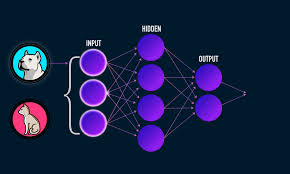

Uma CNN é dividida em duas partes: uma é responsável por extrair as cacateristicas da imagem e a outra é a rede neural em si. Inicialmente, a matriz de pixels da imagem passará por um processo de _Kernel_, que nada mais é do que reduzir a matriz de pixels do tamanho original. 

![alt text](https://raw.githubusercontent.com/cleuton/FaceGuard/master/CNN/images/convolucao.jpg)

Em seguida, essa matriz passa pelo _Padding_, fazendo com que a matriz reduzida mantenha as mesmas dimensões da imagem original. 

A próxima etapa é o _Pooling_, que tem o objetivo de diminuit as dimensões da imagem a fim de reduzir a quantidade de informações que a rede irá processar. 

![alt text](https://miro.medium.com/max/565/1*zXF0FNzzLaxN9zwA8efGww.jpeg)

_Fonte da Imagem: http://cs231n.github.io/convolutional-networks/_

Como foi dito, uma CNN é divida em duas partes (processo de extração de caracteristicas e a rede neural), portanto, a camada que separa essas duas partes é conhecida como _Flatten_, que converte a nossa matriz em um vetor. 

![alt text](https://miro.medium.com/max/953/1*_Cb1dzBhciwRi9y1-J6qjQ.png)

_Fonte da Imagem_: https://www.superdatascience.com/blogs/convolutional-neural-networks-cnn-step-3-flattening

Todas as etapas listadas até aqui serviram para **preparar a imagem** para entrara na camada de entrada da rede neural para seja possível ocorrer o seu **aprendizado**.  


In [0]:
def conv3x3(input_x,nb_filters):
    # Prepara a camada convolucional
    return Conv2D(nb_filters, kernel_size=(3,3), use_bias=False,
               activation='relu', padding="same")(input_x)

In [23]:
# Normaliza os valores dos pixels, sendo representados em uma faixa de 0 a 1
x_treino = x_treino.astype('float32')
x_teste = x_teste.astype('float32')
x_treino /= 255.0
x_teste /= 255.0

# Converte os rótulos para "One-hot encoding": 
y_treino = keras.utils.to_categorical(y_treino, nb_class)
y_teste = keras.utils.to_categorical(y_teste, nb_class)

# Cria o modelo executando um treino e avaliação:
inputs = Input(shape=(img_h, img_w, 1))
x = conv3x3(inputs, 32)
x = conv3x3(x, 32)
x = MaxPooling2D(pool_size=(2,2))(x) 
x = conv3x3(x, 64)
x = conv3x3(x, 64)
x = MaxPooling2D(pool_size=(2,2))(x) 
x = conv3x3(x, 128)
x = MaxPooling2D(pool_size=(2,2))(x) 
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
preds = Dense(nb_class, activation='softmax')(x)
model = Model(inputs=inputs, outputs=preds)

In [24]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

### 3. Treinamento da CNN e avaliação de desepenho 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 852 samples, validate on 139 samples
Epoch 1/10





852/852 [==============================] - 19s 23ms/step - loss: 0.6077 - acc: 0.7054 - val_loss: 0.7871 - val_acc: 0.4317
Epoch 2/10
852/852 [==============================] - 18s 21ms/step - loss: 0.6085 - acc: 0.7336 - val_loss: 0.7393 - val_acc: 0.4317
Epoch 3/10
852/852 [==============================] - 18s 21ms/step - loss: 0.6045 - acc: 0.7336 - val_loss: 0.8695 - val_acc: 0.4317
Epoch 4/10
852/852 [==============================] - 18s 21ms/step - loss: 0.5859 - acc: 0.7336 - val_loss: 0.8916 - val_acc: 0.4317
Epoch 5/10
852/852 [==============================] - 18s 21ms/step - loss: 0.5592 - acc: 0.7336 - val_loss: 1.3167 - val_acc: 0.4317
Epoch 6/10
852/852 [==============================] - 18s 21ms/step - loss: 0.5623 - acc: 0.7336 - val_loss: 0.8522 - val_acc: 0.4317
Epoch 7/10
852/852 [============================

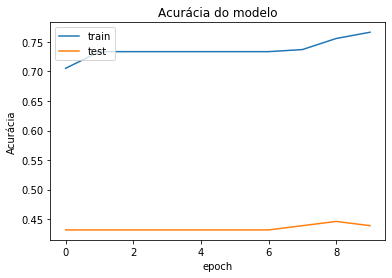

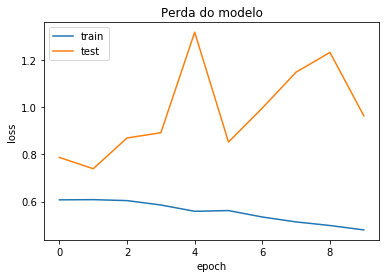

In [25]:
# Cria um callback para salvar o modelo a cada "epoch" de treinamento completada: 
callback = ModelCheckpoint('dogs_cats_saved.h5')

# Treina o modelo (demora cerca de 6 minutos sem GPU):
history = model.fit(x_treino, y_treino,
          batch_size=batch_sz,
          epochs=nb_epochs,
          verbose=1,
          validation_data=(x_teste, y_teste), 
          callbacks=[callback])

# Avalia o modelo com dados de teste:
score = model.evaluate(x_teste, y_teste, verbose=0)
print('Perda:', score[0])
print('Acurácia:', score[1])

# Plota gráficos de perda e acurácia: 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Acurácia do modelo')
plt.ylabel('Acurácia')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perda do modelo')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 3.Validação do Modelo

Para validar a rede treinada, é possível baixar qualquer imagem do google em sua máquina e depois extra-la com a execução da célula abaixo: 

In [27]:
from google.colab import files
files.upload()  #Selecione a imagem que deseja classificar 

Saving gato.jpg to gato.jpg


{'gato.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x12\x12\x10\x12\x10\x10\x12\x15\x15\x10\x15\x10\x10\x15\x15\x15\x10\x15\x10\x15\x10\x10\x15\x15\x15\x16\x16\x15\x15\x15\x15\x18\x1d( \x18\x1a%\x1b\x15\x15!1!%)+...\x17\x1f383,7(-.+\x01\n\n\n\x0e\r\x0e\x17\x10\x10\x1b-\x1f\x1d\x1d---++-+-+++---------------+-----+----+------------\xff\xc0\x00\x11\x08\x00\xb8\x01\x12\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x01\x05\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\x01\x02\x03\x04\x06\x00\x07\x08\xff\xc4\x00;\x10\x00\x01\x03\x02\x04\x03\x06\x03\x06\x06\x01\x05\x00\x00\x00\x00\x01\x00\x02\x11\x03\x04\x05\x12!1AQa\x06\x13"q\x81\x912\xa1\xb1\x14#b\xc1\xd1\xe13BR\x82\xf0\xf1\x15\x07\x16Cr\x92\xff\xc4\x00\x19\x01\x00\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\xff\xc4\x00#\x11\x00\x02\x02\x02\x02\x02\x02\x03\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x11\x03!\x121AQ\

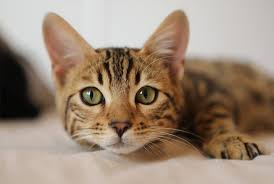


Classificação da Rede: Gato


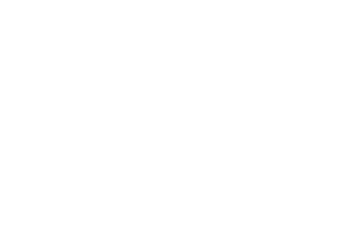

In [28]:
def prepararImagem(imagem):
    test_image = image.img_to_array(imagem.T)
    test_image = np.expand_dims(test_image, axis = 0)    
    return test_image

def mostraCateg(resultado):
    categs = ["Gato", "Cachorro"]
    for idx, val in enumerate(resultado[0]):
        if val == 1:
            return categs[idx]

im = cv2.imread("gato.jpg") #Copie o nome da imagem a ser classificada 
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) #Converte para escala cinza 
imres = cv2.resize(gray, (img_h, img_w), interpolation=cv2.INTER_CUBIC) #Reconfigura o tamanho da imagem para o mesmo utilizado no treinamento 
dados = prepararImagem(imres)
cv2_imshow(im)
plt.axis('off')
ret = model.predict(dados, batch_size=1) #Insere a imagem no modelo 
print()
print("Classificação da Rede:", mostraCateg(ret)) #Mostra o resultado obtido pela rede 

_Referencias_
1. https://github.com/cleuton/FaceGuard/blob/master/CNN/DogsCats.ipynb
https://towardsdatascience.com/ >> Classificador de Gatos e Cachorros 
2. https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166 >> Usuo do google drive para baixar e utilizar o dataset do Kaggle
3. https://www.kaggle.com/c/dogs-vs-cats >> Dataset das imagens dos gatos e cachorros  
4. https://medium.com/machina-sapiens/google-colab-guia-do-iniciante-334d70aad531 >> Uso do GoogleColab
5. https://medium.com/data-hackers/uma-introdu%C3%A7%C3%A3o-as-redes-neurais-convolucionais-utilizando-o-keras-41ee8dcc033e >> Redes Neurais Convolucionais